# Testing the two-level asymptotic form of `Whirl2d`

In [41]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes, Process);

### Create a body undergoing a weak oscillatory translation in `x` direction 

In [42]:
nbody = 1
b1 = let Npts = 64,  # total number of points on circle
         rad = 1.0,   # radius of circle
         xcent = [0.0,0.0],  # initial centroid of circle
         ang = 0.0    # initial angle of circle
         Bodies.Circle(Npts,rad,xcent,ang)
end

#b2 = let Npts = 64,  # total number of points on circle
#         rad = 1.0,   # radius of circle
#         xcent = [4.0,0.0],  # initial centroid of circle
#         ang = 0.0    # initial angle of circle
#         Bodies.Circle(Npts,rad,xcent,ang)
#end

Body: number of points = 64, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]
     max spacing between points = 0.09813534865483665
     min spacing between points = 0.09813534865483566


### Set the streaming motion

In [43]:
sparams = Array{NavierStokes.StreamingParams}(nbody)

ϵ = 0.1  # A/R

sparams[1] = let Ω = 1.0,    # Angular frequency
                 X = 1.0,  # X amplitude
                 Y = 0.0,   # Y amplitude
                 ϕx = 0.0,  # X phase lead
                 ϕy = 0.0  # Y phase lead                
    
    NavierStokes.StreamingParams(Ω, ϵ, X, ϕx, Y, ϕy)
end;
NavierStokes.set_oscil_motion!(b1,sparams[1])

T = 2π/sparams[1].Ω

6.283185307179586

### Create a domain with this body in it

In [44]:
xmin = [-4.0,-4.0]
xmax = [4.0,4.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b1)
#dom = Systems.add_body(dom,b2)

Domain: xmin = [-4.0, -4.0], xmax = [4.0, 4.0]
number of bodies = 1
Body: number of points = 64, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]
     max spacing between points = 0.09813534865483665
     min spacing between points = 0.09813534865483566



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [45]:
Δx = 0.08
dom = Systems.add_grid(dom,Δx)
x = Grids.xcell(dom.grid);
y = Grids.ycell(dom.grid);

### Set the physical and time parameters

In [46]:
Re = 40.0
physparams = let U = [0.0,0.0]
    NavierStokes.set_freestream(U)
end
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

nT = ceil(Int,T/tparams.Δt) # number of time steps in each period

params = (physparams,α,sparams)
tparams

Time step size 0.04

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [47]:
gops, ops = NavierStokes.set_operators_two_level_body!(dom,params);

Setting up LGF table
  0.243130 seconds (140.41 k allocations: 154.599 MiB, 14.62% gc time)
Setting up integrating factor table
  0.002082 seconds (2.18 k allocations: 1010.719 KiB)
Setting up body-to-grid operator
  1.260804 seconds (222.81 k allocations: 163.124 MiB, 2.48% gc time)
Computing Schur complements and inverses
  0.689840 seconds (132.38 k allocations: 59.160 MiB, 2.21% gc time)
  0.263352 seconds (9.88 k allocations: 42.178 MiB, 4.30% gc time)


### Create an initial solution structure

In [48]:
s = NavierStokes.TwoLevelBodySoln(dom)
h = [s]
#TimeMarching.ifherk!(s,tparams,ops)

1-element Array{Whirl2d.ConstrainedSoln{Array{Array{Float64,2},1},Array{Array{Float64,2},1}},1}:
 Solution: t = 0.0


### Advance the solution

In [54]:
@time for i = 1:5*nT
    s = TimeMarching.ifherk!(s,tparams,ops)
    push!(h,s)
end
s

 43.275323 seconds (15.07 M allocations: 13.778 GiB, 5.00% gc time)


Solution: t = 37.91999999999937


### Evaluate the fields of the solution history

In [55]:
@time f = NavierStokes.evaluateFields.(h,dom.grid,gops);
t = map(x -> x.t, f);
ω = map(x -> x.ω, f);
ψ = map(x -> x.ψ, f);
ux = map(x -> x.ux, f);
uy = map(x -> x.uy, f);

  5.596317 seconds (121.52 k allocations: 2.022 GiB, 28.78% gc time)


#### Average over the last period

In [56]:
ψavg = NavierStokes.average(ψ, length(f)-nT+1:length(f));
ωavg = NavierStokes.average(ω, length(f)-nT+1:length(f));

### Plot the solution

#### Level 1 solution

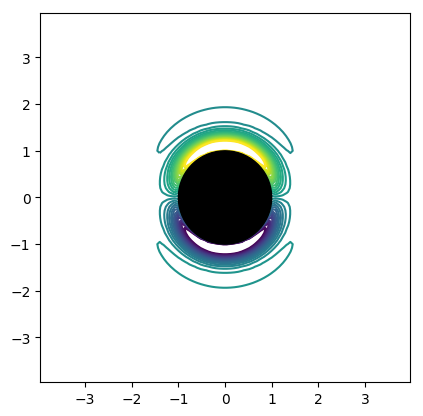

(-3.96, 3.96, -3.96, 3.96)

In [52]:
contour(x,y,transpose(ω[end][1]),linspace(-5,5,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

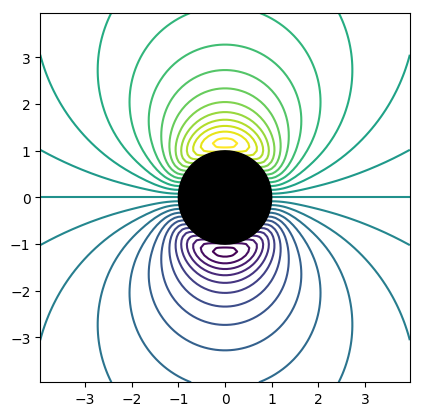

(-3.96, 3.96, -3.96, 3.96)

In [13]:
contour(x,y,transpose(ψ[end][1]),31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

#### Level 2 solution

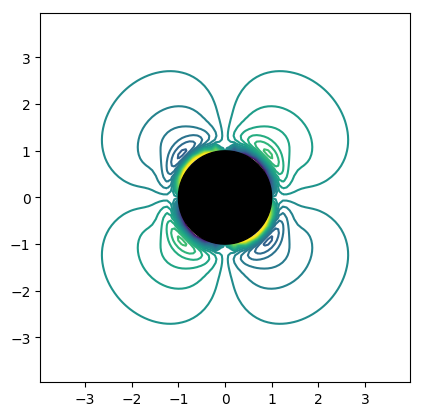

(-3.96, 3.96, -3.96, 3.96)

In [14]:
contour(x,y,transpose(ω[end][2]),linspace(-5,5,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

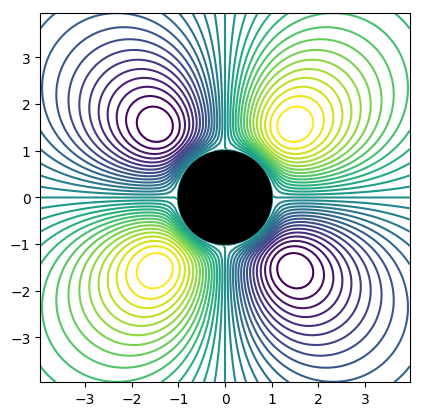

(-3.96, 3.96, -3.96, 3.96)

In [15]:
contour(x,y,transpose(ψ[end][2]),31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

#### Level 2 mean solution

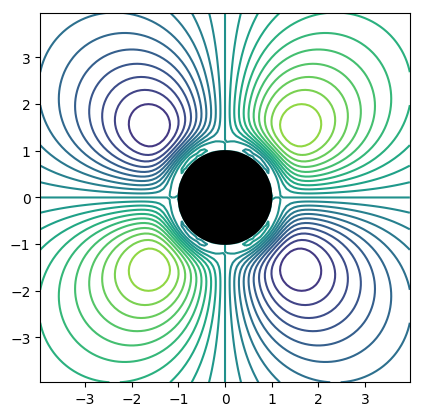

(-3.96, 3.96, -3.96, 3.96)

In [57]:
contour(x,y,ψavg[2],linspace(-0.5,0.5,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

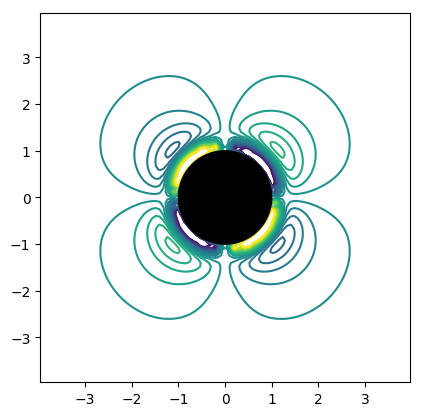

(-3.96, 3.96, -3.96, 3.96)

In [58]:
contour(x,y,ωavg[2],linspace(-5,5,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

### Sample the computed solution

In [18]:
using Interpolations

In [19]:
xsamp = [2.0,1.5]
ysamp = [0.0,1.5]
ψsamp = [Float64[] for x in xsamp]
uxsamp = [Float64[] for x in xsamp]
uysamp = [Float64[] for x in xsamp]
tsamp = Float64[]
for i = 1:length(h)
    ψf = ϵ*ψ[i][1]+ϵ^2*ψ[i][2]
    uxf = ϵ*ux[i][1]+ϵ^2*ux[i][2]
    uyf = ϵ*uy[i][1]+ϵ^2*uy[i][2]
    ψitp = interpolate((Grids.xcell(dom.grid),Grids.ycell(dom.grid)),ψf*Δx,Gridded(Linear()))
    uxitp = interpolate((Grids.xfacex(dom.grid),Grids.yfacex(dom.grid)),uxf,Gridded(Linear()))
    uyitp = interpolate((Grids.xfacey(dom.grid),Grids.yfacey(dom.grid)),uyf,Gridded(Linear()))    
    for j = 1:length(xsamp)
        push!(ψsamp[j],ψitp[xsamp[j],ysamp[j]])
        push!(uxsamp[j],uxitp[xsamp[j],ysamp[j]])
        push!(uysamp[j],uyitp[xsamp[j],ysamp[j]])
    end
end

In [20]:
include(joinpath(Pkg.dir("whirl2d"), "src/Streaming.jl"))
import Streaming

In [21]:
p = let Re = Re, ϵ = ϵ   # use the values of these set above
      Streaming.Params(ϵ,Re)
end
g, r = let xmin = -6.0,
      xmax = 6.0,
      N = 301,
      x = [xmin + (j-1)*(xmax-xmin)/(N-1) for i=1:N, j=1:N],
      y = [xmin + (i-1)*(xmax-xmin)/(N-1) for i=1:N, j=1:N],
      Nᵣ = 500,
      rmax = √2*xmax
      Streaming.Grid(x,y), collect(linspace(1,rmax,Nᵣ))
end

(2-dimensional evaluation grid
, [1.0, 1.015, 1.03, 1.045, 1.06, 1.075, 1.09, 1.105, 1.12, 1.13501  …  8.35028, 8.36528, 8.38028, 8.39528, 8.41028, 8.42528, 8.44028, 8.45528, 8.47028, 8.48528])

In [22]:
s₁ = Streaming.FirstOrder(p,r)
s̄₂ = Streaming.SecondOrderMean(p,r)
s₂ = Streaming.SecondOrder(p,r)

Amplitude of order 2 streaming exact solution


In [23]:
tex = 0.0
sfull = Streaming.Evaluate(tex,p,g,s₁,s̄₂,s₂)

Streaming exact solution at t = 0.0


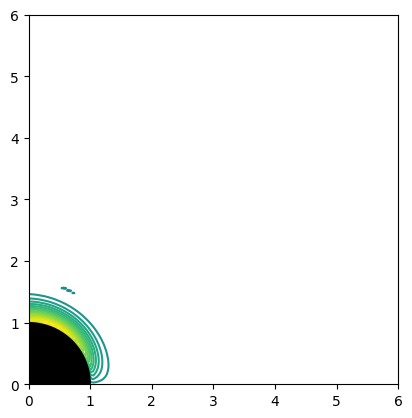

(0, 6.0)

In [24]:
contour(g.x,g.y,sfull.ω,linspace(-1,1,30))
R = 1.0
zc = R*exp.(im*linspace(0,2π,100))
fill(real(zc),imag(zc),color="k",zorder=2)
axis("scaled")
xlim(0,maximum(g.x))
ylim(0,maximum(g.y))

### Sample the history of exact solution at a few points

In [25]:
gsamp = Streaming.Grid(xsamp,ysamp)

1-dimensional evaluation grid


#### Set the time range over which to evaluate

In [26]:
tr = let t₀ = 0.0,
    t₁ = 10.0*2π,
    Δt = 2π/40
    t₀:Δt:t₁
end

0.0:0.15707963267948966:62.83185307179586

#### Evaluate the exact solution at sample points over selected time range

In [27]:
hexact = Streaming.Evaluate(tr,p,gsamp,s₁,s̄₂,s₂);
uxex, uyex = Streaming.cartesian(hexact,gsamp);

#### Compare the exact solution with the computed solution

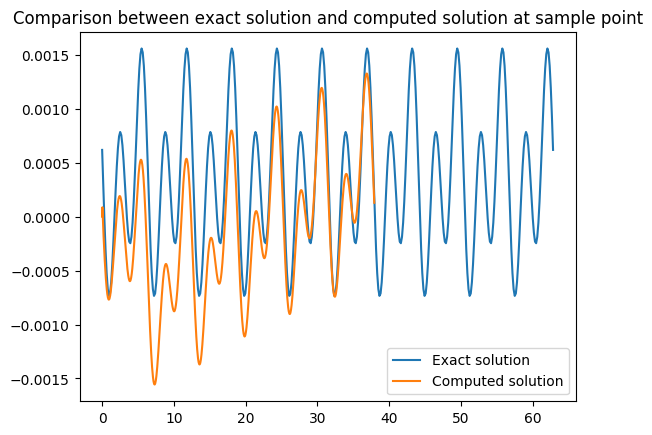

PyObject <matplotlib.legend.Legend object at 0x12d0061d0>

In [29]:
isamp = 2  # which sample point is being plotted
plot(hexact.t,uxex[isamp],t,uxsamp[isamp])
title("Comparison between exact solution and computed solution at sample point")
legend(["Exact solution","Computed solution"])